<a href="https://colab.research.google.com/github/kyle-gao/PointCloudTest/blob/main/O3dPointCloudOpinionDatasetAJavareriplyfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/MEPP-team/PC-MSDM/blob/master/main.cpp C++ implementation

Implementing PC-MSDM

Gabriel Meynet, Julie Digne, Guillaume Lavoué. PC-MSDM: A quality metric for 3D point clouds. 11th International Conference on Quality of Multimedia Experience (QoMEX 2019), Jun 2019, Berlin, Germany. ffhal-02162104f

In [79]:
%matplotlib inline

In [80]:
!git clone https://github.com/AlirezaJav/IRPC-Dataset

fatal: destination path 'IRPC-Dataset' already exists and is not an empty directory.


In [81]:
!pip install open3d

In [82]:
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from zipfile import ZipFile
import time
import open3d as o3d
import plotly.graph_objects as go
import scipy

In [83]:
MOS = pd.read_excel("/content/IRPC-Dataset/MOS Scores.xlsx")
MOS_CommonSubjects = pd.read_excel("/content/IRPC-Dataset/MOS_CommonSubjects.xlsx")

In [84]:
MOS_CommonSubjects.head()

Unnamed: 0 Unnamed: 1  ... Unnamed: 5 Unnamed: 6
0         NaN        NaN  ...        NaN        NaN
1         NaN        NaN  ...        NaN        NaN
2         NaN        NaN  ...     Rcolor      Rmesh
3         NaN     Facade  ...    2.44444    3.66667
4         NaN        NaN  ...    3.33333    3.77778

[5 rows x 7 columns]

In [86]:
target_folder = "/content/Original_PC/"
if not(os.path.isdir(target_folder)):
  os.mkdir(target_folder)
  !7z e "/content/IRPC-Dataset/Original Point Clouds/12-bit/Facade_O12.zip.001" -o"/content/Original_PC"
  !7z e "/content/IRPC-Dataset/Decoded Point Clouds/PCL/Facade_PCL_L.zip" -o"/content/Distorted_PC"

In [87]:
ref_pc = o3d.io.read_point_cloud('/content/Original_PC/Facade_O12.ply')

In [88]:
dis_pc = o3d.io.read_point_cloud('/content/Distorted_PC/Facade_PCL_L.ply', format='ply')

In [89]:
dis_pc

PointCloud with 83031 points.

In [90]:
dis_tree = o3d.geometry.KDTreeFlann(dis_pc)

In [91]:
ref_tree = o3d.geometry.KDTreeFlann(ref_pc)

In [92]:
#.search_knn_vector_3d(point,k)
# returns 
# k, indices, distances
[k, idx, z] = dis_tree.search_knn_vector_3d(dis_pc.points[1500], 200)

In [93]:
np.asarray(dis_pc.colors)[idx[1:], :] = [0, 1, 0]

In [94]:
points = np.asarray(dis_pc.points)
colors = np.asarray(dis_pc.colors)

In [95]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

PSNR implementation from MPEG

Mekuria et al. "INTERNATIONAL ORGANISATION FOR STANDARDISATION
ORGANISATION INTERNATIONALE DE NORMALISATION
ISO/IEC JTC1/SC29/WG11
CODING OF MOVING PICTURES AND AUDIO
" 2016.

![image.png](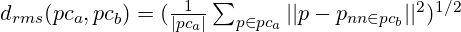
)



image.png


image.png

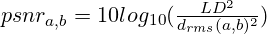

image.png

In [96]:
length = 1596085 
indices = np.zeros(length)
distances = np.zeros(length)
for i in range(length):
  ref_point = ref_pc.points[i]
  [_,idx,z] = dis_tree.search_knn_vector_3d(ref_point,1)
  indices[i]=idx.pop()
  distances[i]=z.pop()

In [97]:
def d_rms2 (pc_a,pc_b):
  total = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,idx,_] = b_tree.search_knn_vector_3d(ref_point,1)
    idx = idx.pop()
    diff = ref_point-pc_b.points[idx]
    z = np.sum(diff**2)
    total += z
  drms = np.sqrt(total/l_a)
  return drms

In [98]:
def d_rms (pc_a,pc_b):
  total = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,_,z] = b_tree.search_knn_vector_3d(ref_point,1)
    total += z.pop()
  drms = np.sqrt(total/l_a)
  return drms

In [99]:
def d_rms_hausd (pc_a,pc_b):
  total = 0
  maximum = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,_,z] = b_tree.search_knn_vector_3d(ref_point,1)
    z = z.pop()
    total += z
    maximum = np.maximum(maximum,z)
  drms = np.sqrt(total/l_a)
  dhaus = np.sqrt(maximum)
  return drms,dhaus

In [100]:
def d_symmetric(pc_a,pc_b):
  d_rmsa,d_hausa = d_rms_hausd(pc_a,pc_b)
  d_rmsb,d_hausb = d_rms_hausd(pc_b,pc_a)
  return np.maximum(d_rmsa,d_rmsb), np.maximum(d_hausa,d_hausb)

In [101]:
d_sym_rms,d_sym_haus = d_symmetric(ref_pc,dis_pc)

In [102]:
def psnr_rms(pc_a,pc_b):
  drms = d_rms(pc_a,pc_b)
  ld = np.sum((pc_a.get_max_bound() - pc_a.get_min_bound() )**2)
  psnr = np.log10(ld/drms**2)
  return psnr

In [103]:
def psnr_rms_sym(pc_a,pc_b):
  psnra = psnr_rms(pc_a,pc_b)
  psnrb = psnr_rms(pc_a,pc_b)
  return np.maximum(psnra,psnrb)

In [104]:
psnr = psnr_rms_sym(ref_pc,dis_pc)

In [105]:
def plot_surface(X,Y,Z):  
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  # Plot the surface.
  surf = ax.plot_surface(X, Y, Z, cmap="gray",
                       linewidth=0, antialiased=False)
  fig.show()

#Fit Quadratic Surface

In [106]:
def quad_surface_z (coef,x,y):
  """
  Args:
  coef-(6,) array of coefficients of quadratic surface
  x
  y
  Returns z according to quadratic surface
  """
  return coef[0]*x**2 + coef[1]*y**2 + coef[2]*x*y + coef[3]*x + coef[4]*y + coef[5]

def sqdist_to_quad_plane(soln,x,y,P_0):
  """Euclidean length of (x,y,Z(x,y))  
  """
  return (x-P_0[0])**2+(y-P_0[1])**2+(quad_surface_z(soln,x,y)-P_0[0])**2

In [107]:
def quadratic_matrix (X,Y):
  """
  Args:
  X,Y 1D array of coordinates
  Returns:
  (n,6) array of quadratic + linear features [X^2,Y^2,XY,X,Y,1]
  """
  poly_m = np.stack([X**2,Y**2,X*Y,X,Y,np.ones(X.shape)],axis=-1)
  return poly_m

In [108]:
X = np.arange(-2, 4, 0.3)
X = X
Y = np.arange(-3, 3, 0.3)
Y = Y
poly_m=quadratic_matrix(X,Y)

In [109]:
poly_m

array([[ 4.00000000e+00,  9.00000000e+00,  6.00000000e+00,
        -2.00000000e+00, -3.00000000e+00,  1.00000000e+00],
       [ 2.89000000e+00,  7.29000000e+00,  4.59000000e+00,
        -1.70000000e+00, -2.70000000e+00,  1.00000000e+00],
       [ 1.96000000e+00,  5.76000000e+00,  3.36000000e+00,
        -1.40000000e+00, -2.40000000e+00,  1.00000000e+00],
       [ 1.21000000e+00,  4.41000000e+00,  2.31000000e+00,
        -1.10000000e+00, -2.10000000e+00,  1.00000000e+00],
       [ 6.40000000e-01,  3.24000000e+00,  1.44000000e+00,
        -8.00000000e-01, -1.80000000e+00,  1.00000000e+00],
       [ 2.50000000e-01,  2.25000000e+00,  7.50000000e-01,
        -5.00000000e-01, -1.50000000e+00,  1.00000000e+00],
       [ 4.00000000e-02,  1.44000000e+00,  2.40000000e-01,
        -2.00000000e-01, -1.20000000e+00,  1.00000000e+00],
       [ 1.00000000e-02,  8.10000000e-01, -9.00000000e-02,
         1.00000000e-01, -9.00000000e-01,  1.00000000e+00],
       [ 1.60000000e-01,  3.60000000e-01, -2.400

In [110]:
coef=[0,0, 0, 1,-1,0]

In [111]:
t1 = time.time()
soln = np.linalg.lstsq(poly_m,quad_surface_z(coef,X,Y))[0]
print(time.time()-t1)
print(soln)

0.0019085407257080078
[ 0.1  0.1 -0.2  0.3 -0.3  0.6]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [112]:
np.dot(np.linalg.pinv(poly_m),quad_surface_z(coef,X,Y))

array([ 0.1,  0.1, -0.2,  0.3, -0.3,  0.6])

In [113]:
t1 = time.time()
soln2 = scipy.linalg.lstsq(poly_m,quad_surface_z(coef,X,Y),lapack_driver="gelsy")[0]
print(time.time()-t1)
print(soln2)

0.0013625621795654297
[ 0.1  0.1 -0.2  0.3 -0.3  0.6]


In [114]:
XX, YY = np.meshgrid(X, Y)
ZZ = quad_surface_z(coef,XX,YY)

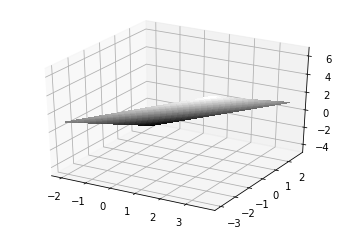

In [115]:
plot_surface(XX,YY,quad_surface_z(coef,XX,YY))

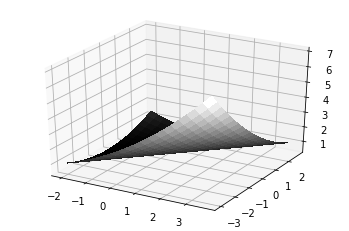

In [116]:
plot_surface(XX,YY,quad_surface_z(soln2,XX,YY))

In [117]:
def curvature(coef):
  """
  Args:
  coef-[a,b,c,d,e,f] coordinates of quadratic fitting
  returns:
  float-scalar curvature
  """
  [a,b,c,d,e,f] = coef
  return ((1+d**2)*a + (1+e**2)*b - 4*a*b*c)/np.power((1+e**2 + d**2),3/2)

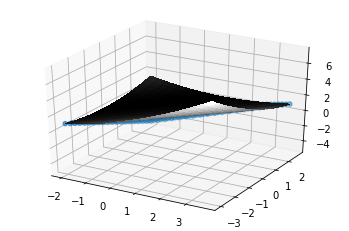

In [118]:
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  # Plot the surface.
  surf = ax.plot_surface(XX, YY, quad_surface_z(soln2,XX,YY), cmap="gray",linewidth=0, antialiased=False)
  scatter = ax.scatter(XX,YY,ZZ)
  fig.show()

In [119]:
[k, idx, z] = dis_tree.search_knn_vector_3d(dis_pc.points[15000], 100)
points = np.asarray(dis_pc.points)[idx]

In [120]:
[k, idx, z] = dis_tree.search_knn_vector_3d(dis_pc.points[15000], 5)
points10 = np.asarray(dis_pc.points)[idx]

In [121]:
X = points[:,0]
X = X-X[0]
Y = points[:,1]
Y = Y-Y[0]
Z = points[:,2]
Z = Z-Z[0]

In [122]:
def get_XYZ(points):
  """
  Args:
  points-2D array (n,3) of points
  Returns:
  returns X,Y,Z 1D array (n,) of coordinates
  """
  X = points[:,0]
  X = X-X[0]
  Y = points[:,1]
  Y = Y-Y[0]
  Z = points[:,2]
  Z = Z-Z[0]
  return X,Y,Z
  


In [123]:
X10,Y10,Z10 = get_XYZ(points10)

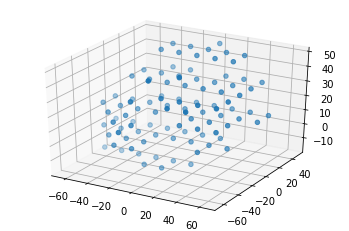

In [124]:
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  # Plot the surface.
  #surf = ax.plot_surface(XX, YY, quad_surface_z(soln2,XX,YY), cmap="gray",linewidth=0, antialiased=False)
  scatter = ax.scatter(X,Y,Z)
  fig.show()

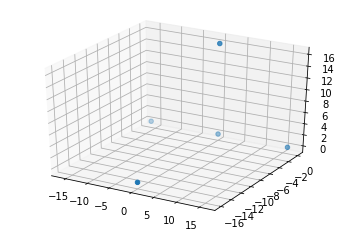

In [125]:
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  # Plot the surface.
  #surf = ax.plot_surface(XX, YY, quad_surface_z(soln2,XX,YY), cmap="gray",linewidth=0, antialiased=False)
  scatter = ax.scatter(X10,Y10,Z10)
  fig.show()

In [126]:
poly_m = quadratic_matrix(X,Y)

In [127]:
soln = scipy.linalg.lstsq(poly_m,Z,lapack_driver="gelsy")[0]

In [128]:
def fit_quad_surface(tree, pc, p, k, new_point=None):
  """
  Args:
  p - int: index of reference points
  k - int: number of neighbours to retrieve from tree
  tree - o3d.geometry.KDTreeFlann object
  new_point - None or np.array([x,y,z])
  Returns:
  X,Y,Z - 1D array of coordinates
  soln - solution to the quadratic surface fitting (a,b,c,d,e,f)
  """
  _, idx, _ = tree.search_knn_vector_3d(p, k)
  points = np.asarray(pc.points)[idx]



  X = points[:,0]
  X = X-p[0]
  Y = points[:,1]
  Y = Y-p[1]
  Z = points[:,2]
  Z = Z-p[2]

  if new_point is not None:
    points = np.insert(points,0,new_point,axis=0)

  poly_m = quadratic_matrix(X,Y)
  soln = scipy.linalg.lstsq(poly_m,Z,lapack_driver="gelsy")[0]


  return X,Y,Z,soln



In [129]:
X,Y,Z,soln2 = fit_quad_surface(dis_tree, dis_pc, dis_pc.points[15000], 8)

In [130]:
def plot_fit_surface(X,Y,Z,coef):
  """
  Plots scatter plot of points and the fitted surface
  
  Args:
  X,Y,Z: 1D array of coordinates
  coef: [a,b,c,d,e,f] quadratic fitting parameters

  """
  XX = np.linspace(X.max(),X.min(),num=20)
  YY = np.linspace(Y.max(),Y.min(),num=20)
  XX, YY = np.meshgrid(XX, YY)
  ZZ = quad_surface_z(coef,XX,YY)
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  # Plot the surface.
  surf = ax.plot_surface(XX, YY,ZZ, cmap="gray",linewidth=0, antialiased=False)
  scatter = ax.scatter(X,Y,Z)

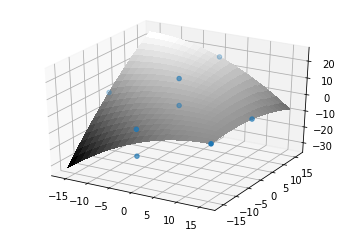

In [131]:
plot_fit_surface(X,Y,Z,soln2)

In [132]:
def get_h_neighbourhood(tree, pc, p, h):
  """
  Args:
  tree - o3d.geometry.KDTreeFlann object
  h - float: neighbourhood radius
  p - (3,) array, neighbourhood center

  """
  _, idx, _ = tree.search_radius_vector_3d(p, h)
  points = np.asarray(pc.points)[idx]
  return points

In [133]:
  [k, idx, z] = dis_tree.search_radius_vector_3d(dis_pc.points[15000], 25)
  points = np.asarray(dis_pc.points)[idx]
  p = dis_pc.points[15000]

In [134]:
h = np.linalg.norm(dis_pc.get_oriented_bounding_box().extent)*0.02

In [135]:
def get_neighbourhood_curvatures(tree,pc,p,h,k):
  """
  Args:
  tree - o3d.geometry.KDTreeFlann object
  pc - o3d.PointCloud object
  h - float: neighbourhood radius
  p - (3,) array, neighbourhood center

  """
  #points = get_h_neighbourhood(tree,pc,p,h)
  _,idx,sq_dist = tree.search_radius_vector_3d(p,h)
  points = np.asarray(pc.points)[idx]
  curvatures = []
  for p in points:
    _,_,_,soln = fit_quad_surface(tree,pc,p,k)
    curv = curvature(soln)
    curvatures.append(curv)
  curvatures = np.asarray(curvatures)
  return np.stack((curvatures,sq_dist),axis=-1)

In [175]:
  #def get_curvatures(dis_tree,dis_pc,ref_tree,ref_pc,dis_p,h,k):
  _,idx,dis_sq_dist = dis_tree.search_radius_vector_3d(p,h)
  dis_points = np.asarray(dis_pc.points)[idx]
  n_points = dis_points.shape[0]

  ref_curvatures = np.zeros(n_points)
  dis_curvatures = np.zeros(n_points)
  ref_points = np.zeros((n_points,3))

  for j,dis_p in enumerate(points):
    _,_,_,dis_soln = fit_quad_surface(dis_tree,dis_pc,dis_p,k)
    dis_curvatures[j] = curvature(dis_soln)

    ref_p = get_ref_p(dis_p,ref_tree,ref_pc,k)
    ref_points[j,:] = ref_p
    
    _,_,_,ref_soln = fit_quad_surface(ref_tree,ref_pc,ref_p,k)
    ref_curvatures[j] = curvature(ref_soln)
  
  
  








In [177]:
dis_points

array([[2312.,  507., 1050.],
       [2296.,  507., 1050.],
       [2312.,  491., 1050.],
       [2312.,  507., 1034.],
       [2312.,  523., 1050.],
       [2312.,  507., 1066.],
       [2296.,  491., 1050.],
       [2296.,  523., 1050.],
       [2296.,  507., 1066.],
       [2312.,  491., 1034.],
       [2312.,  523., 1034.],
       [2328.,  507., 1034.],
       [2312.,  523., 1066.],
       [2296.,  491., 1066.],
       [2296.,  523., 1066.],
       [2328.,  491., 1034.],
       [2328.,  523., 1034.],
       [2312.,  507., 1018.],
       [2312.,  475., 1050.],
       [2296.,  475., 1050.],
       [2280.,  507., 1066.],
       [2296.,  507., 1082.],
       [2296.,  539., 1050.],
       [2312.,  523., 1018.],
       [2328.,  507., 1018.],
       [2328.,  475., 1050.],
       [2344.,  507., 1034.],
       [2312.,  539., 1034.],
       [2280.,  491., 1066.],
       [2296.,  475., 1066.],
       [2296.,  491., 1082.],
       [2280.,  523., 1066.],
       [2296.,  539., 1034.],
       [22

In [176]:
ref_points

array([[1895.7996631 , 2487.0639827 ,  361.29839063],
       [1877.48080399, 2491.27926078,  362.89577688],
       [1898.4738158 , 2477.54364269,  358.27836748],
       [1895.80772107, 2490.88092105,  378.2378572 ],
       [1911.97630916, 2485.27873615,  364.60382568],
       [1881.34413715, 2478.68108211,  359.75200668],
       [1881.82954953, 2489.03647188,  376.74371807],
       [1898.58484688, 2477.49099936,  350.96809587],
       [1909.76397328, 2474.11674914,  360.88477378],
       [1893.99910055, 2507.95903839,  384.75128497],
       [1911.80019495, 2491.4324746 ,  377.50225616],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.

In [172]:
dis_sq_dist[1]

256.0

In [170]:
points[0]-points[1]

array([16.,  0.,  0.])

In [169]:
dis_p

array([1912., 2491.,  378.])

In [164]:
for j,dis_p in enumerate(points):
  print(dis_p)

[1896. 2491.  362.]
[1880. 2491.  362.]
[1896. 2475.  362.]
[1896. 2491.  378.]
[1912. 2491.  362.]
[1880. 2475.  362.]
[1880. 2491.  378.]
[1896. 2475.  346.]
[1912. 2475.  362.]
[1896. 2507.  378.]
[1912. 2491.  378.]


In [161]:
ref_p

array([1911.80019495, 2491.4324746 ,  377.50225616])

In [136]:
get_curvatures_test = get_neighbourhood_curvatures(dis_tree,dis_pc,dis_pc.points[15000],100,7)

#d = z-zo 
#x,y = argmin {x,y} (x-xo)^2+(y-yo)^2 + (Q(x,y)-Z)^2
#x,y,z = x,y,Q(x,y)

except we shift coordinates so xo,yo,zo are at the origin

#Project Point

In [157]:
"""def project_point(point,soln):
  results = scipy.optimize.minimize( (lambda X:sqdist_to_quad_plane(soln,X[0],X[1],point)), (0,0), method='Nelder-Mead', tol=1e-6) #can give jacobian for big speedup
  [x,y] = results.x
  return np.array([x,y,quad_surface_z(soln,x,y)])"""

"def project_point(point,soln):\n  results = scipy.optimize.minimize( (lambda X:sqdist_to_quad_plane(soln,X[0],X[1],point)), (0,0), method='Nelder-Mead', tol=1e-6) #can give jacobian for big speedup\n  [x,y] = results.x\n  return np.array([x,y,quad_surface_z(soln,x,y)])"

In [138]:
p = dis_pc.points[15000]

In [139]:
_,_,_,soln = fit_quad_surface(dis_tree,dis_pc,p,6)

In [140]:
 (lambda X:sqdist_to_quad_plane(soln,X[0],X[1],p))

<function __main__.<lambda>>

In [141]:
t1= time.time()
#should test different methods, speed is kinda slow
#can give jacobian for speed up
results = scipy.optimize.minimize(  (lambda X:sqdist_to_quad_plane(soln,X[0],X[1],p)), (0,0), method='Nelder-Mead', tol=1e-8).x
print(time.time()-t1)

0.01767706871032715


In [142]:
fit_quad_surface(ref_tree,ref_pc,p,8)

(array([-3.,  2.,  0., -1.,  4., -3.,  7., -4.]),
 array([-5., -7., -7., -5., -7., -8., -5., -6.]),
 array([ 1.,  1., -4.,  7.,  4., -5.,  5.,  7.]),
 array([  0.12077267,  -1.33805306,  -0.2765428 ,  -1.78561404,
        -14.71090819, -37.52129229]))

In [143]:
def get_ref_p(dis_p,ref_tree,ref_pc,k):
  """
  Args:
  dis_p : point on distorted point cloud
  ref_tree : reference point cloud tree
  ref_pc : refrence point cloud
  k : number of neighbhours to retrive for surface fitting
  Returns:
  projection of dis_p on surface fitted on ref_pc
  """
  #_,idx,_ = ref_tree.search_knn_vector_3d(dist_p, k)
  #ref_points = ref_pc.points[idx]
  
  
  X,Y,Z,soln = fit_quad_surface(ref_tree,ref_pc,dis_p,k) #fit quadratic surface on closest point in reference point cloud, #the plane's coordinate has dis_p as its origin.
  #the returns are in dis_p centered coordinates

  #the distorted point is located at (0,0,0)
  proj_xy = scipy.optimize.minimize(  (lambda arg:sqdist_to_quad_plane(soln,arg[0],arg[1],[0,0,0])), (0,0), method='Nelder-Mead', tol=1e-6).x #find closest point's (x,y) on reference quadratic surface to the distorted point
  proj_z = quad_surface_z(soln,proj_xy[0],proj_xy[1]) #find the z value of the closest point on ref surface

  proj_point = np.append(proj_xy,proj_z) + dis_p #back to point cloud coordinates.

  return proj_point

In [144]:
p = dis_pc.points[40000]

In [145]:
projected_point = get_ref_p(p,ref_tree,ref_pc,8)
projected_point

array([2309.23764271,  506.23876105, 1047.44320558])

In [146]:
def get_ref_surface(dis_p,ref_tree,ref_pc,k):
  """
  Not needed for now
  """
  proj_point = get_ref_p(dis_p,ref_tree,ref_pc,k) #proj point is already in dis_p centered coordinates
  X,Y,Z,soln = fit_quad_surface(ref_tree,ref_pc,proj_point,k,new_point=proj_point)
  return X,Y,Z,soln

In [147]:
answer = get_ref_surface(p,ref_tree,ref_pc,8)
answer

(array([ 1.76235729, -0.23764271,  1.76235729, -2.23764271,  0.76235729,
        -0.23764271,  0.76235729,  2.76235729]),
 array([-0.23876105, -1.23876105, -1.23876105,  0.76123895, -0.23876105,
        -3.23876105,  0.76123895,  1.76123895]),
 array([-0.44320558,  1.55679442, -2.44320558, -2.44320558, -3.44320558,
         1.55679442, -3.44320558,  1.55679442]),
 array([ 0.71172754, -0.7007395 ,  1.63471608, -0.74524481, -2.97116391,
        -2.18140129]))

In [148]:
fit_quad_surface(ref_tree,ref_pc,projected_point,k,projected_point)

(array([ 1.76235729, -0.23764271,  1.76235729, -2.23764271,  0.76235729,
        -0.23764271,  0.76235729,  2.76235729, -1.23764271,  0.76235729,
         2.76235729]),
 array([-0.23876105, -1.23876105, -1.23876105,  0.76123895, -0.23876105,
        -3.23876105,  0.76123895,  1.76123895,  3.76123895,  2.76123895,
        -2.23876105]),
 array([-0.44320558,  1.55679442, -2.44320558, -2.44320558, -3.44320558,
         1.55679442, -3.44320558,  1.55679442,  0.55679442, -3.44320558,
        -4.44320558]),
 array([ 0.17949463,  0.24657652,  0.47728434, -0.48071717, -0.34609981,
        -2.18474247]))

In [149]:
t1 = time.time()
curvatures_dis = get_neighbourhood_curvatures(dis_tree,dis_pc,p,h/2,6)
dis_dist_var = curvatures_dis[:,1].var()
weighted_curvatures_dis = curvatures_dis[:,0] * np.exp(-curvatures_dis[:,1]/dis_dist_var)
print(time.time()-t1)

0.03307056427001953


In [150]:
t1=time.time()
curvatures_ref = get_neighbourhood_curvatures(ref_tree,ref_pc,projected_point,h/2,6)
ref_dist_var = curvatures_ref[:,1].var()
weighted_curvatures_ref = curvatures_ref[:,0]*np.exp(-curvatures_ref[:,1]/ref_dist_var)
print(time.time()-t1)

0.31821298599243164


In [151]:
def L_C_S_at_p(dis_curvatures,ref_curvatures,eps = 1e-8):
  dis_distance_var = dis_curvatures[:,1].var()
  ref_distance_var = ref_curvatures[:,1].var()

  dis_weighted_curvatures = dis_curvatures[:,0] * np.exp(-dis_curvatures[:,1]/dis_distance_var)
  ref_weighted_curvatures = ref_curvatures[:,0] * np.exp(-ref_curvatures[:,1]/ref_distance_var)  
  
  mu_r = ref_weighted_curvatures.mean()
  mu_d = dis_weighted_curvatures.mean()
  L = np.abs(mu_r-mu_d)/(np.maxmimum(mu_r,mu_d)+eps)

  sig_r = ref_weighted_curvatures.var()
  sig_d = dis_weighted_curvatures.var()
  C = np.abs(sig_r-sig_d)/(np.maxmimum(sig_r,sig_d)+eps)


In [152]:
weighted_curvatures_ref.shape

(1209,)

In [153]:
weighted_curvatures_dis.shape

(50,)